# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_38', 'ORACLE.run1_44', 'ORACLE.run1_8', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_14', 'ORACLE.run1_50', 'ORACLE.run1_26'}


{'ORACLE.run2_26', 'ORACLE.run2_14', 'ORACLE.run2_32', 'ORACLE.run2_20', 'ORACLE.run2_44', 'ORACLE.run2_38', 'ORACLE.run2_50', 'ORACLE.run2_8'}


tensor([[[-0.0955,  1.1942, -0.1146,  ..., -0.9840, -0.2675, -0.5732],
         [-0.6592, -0.3057,  1.0891,  ...,  0.2484, -1.4617, -0.4872]],

        [[-0.4662,  0.7090,  0.5730,  ..., -1.3014, -1.2237, -0.1165],
         [-1.1752, -0.3302,  1.1558,  ...,  0.4273, -0.1554,  1.2626]],

        [[ 0.6763, -0.3671, -0.7922,  ...,  0.8212,  1.4202,  0.3381],
         [ 0.8598,  0.7053, -0.9178,  ..., -0.7826,  0.4831, -1.1980]],

        ...,

        [[ 1.0255, -0.2498, -1.2227,  ...,  0.6639,  1.0255, -0.6771],
         [ 0.5785,  0.7428, -0.3878,  ..., -1.0123, -0.6376, -1.1701]],

        [[ 0.0260, -1.0137,  0.2924,  ...,  0.9227,  0.4808,  1.0981],
         [ 0.8122,  0.4354, -1.1631,  ..., -0.1235,  1.2996, -0.2339]],

        [[ 0.4980,  0.3408, -0.7471,  ..., -0.4718,  1.2779,  1.0616],
         [-0.4260,  1.1468, -0.0328,  ..., -1.1141, -0.0590, -0.2556]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 48.5978, train_label_loss: 3.1652, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3162.8713, train_label_loss: 0.9541, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3155.3744, train_label_loss: 0.7430, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3161.8426, train_label_loss: 0.7685, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3148.4571, train_label_loss: 0.6421, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3149.1117, train_label_loss: 0.8939, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3147.6775, train_label_loss: 0.6359, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3134.0438, train_label_loss: 0.3113, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3146.3749, train_label_loss: 0.6749, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3150.5227, train_label_loss: 0.4541, 


epoch: 1, source_val_acc_label: 0.6745, target_val_acc_label: 0.6617, source_val_label_loss: 87.5992, target_val_label_loss: 120.3444, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.7307, train_label_loss: 55.2248, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3172.6637, train_label_loss: 0.6441, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3176.7156, train_label_loss: 0.4356, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3178.3229, train_label_loss: 1.1574, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3180.8581, train_label_loss: 0.9294, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3193.6317, train_label_loss: 0.6799, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3185.8507, train_label_loss: 1.0008, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3167.3280, train_label_loss: 0.6151, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3193.8270, train_label_loss: 0.6484, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3188.7920, train_label_loss: 0.3558, 


epoch: 2, source_val_acc_label: 0.8015, target_val_acc_label: 0.7943, source_val_label_loss: 0.5597, target_val_label_loss: 0.6415, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.7448, train_label_loss: 0.6047, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3173.2793, train_label_loss: 0.1939, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3173.9635, train_label_loss: 0.4842, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3168.3812, train_label_loss: 0.3004, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3180.1125, train_label_loss: 0.4707, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3178.5782, train_label_loss: 0.9479, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3192.5654, train_label_loss: 0.5969, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3176.1066, train_label_loss: 0.3012, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3193.5096, train_label_loss: 0.4030, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3180.7003, train_label_loss: 0.1991, 


epoch: 3, source_val_acc_label: 0.7953, target_val_acc_label: 0.7842, source_val_label_loss: 0.5639, target_val_label_loss: 0.6241, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.7384, train_label_loss: 0.5853, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3170.5691, train_label_loss: 0.2291, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3176.2539, train_label_loss: 0.8816, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3177.1043, train_label_loss: 0.6926, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3157.6033, train_label_loss: 0.7066, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3180.5553, train_label_loss: 0.3329, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3179.0244, train_label_loss: 0.9037, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3163.6933, train_label_loss: 0.4718, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3183.6780, train_label_loss: 0.2951, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3177.7256, train_label_loss: 0.3856, 


epoch: 4, source_val_acc_label: 0.8258, target_val_acc_label: 0.8121, source_val_label_loss: 0.4940, target_val_label_loss: 0.5528, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 4.7335, train_label_loss: 0.0720, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3169.6435, train_label_loss: 0.2429, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3188.2360, train_label_loss: 0.7525, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3171.6531, train_label_loss: 0.6525, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3179.7607, train_label_loss: 0.3844, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3185.3934, train_label_loss: 0.1032, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3174.2800, train_label_loss: 0.3424, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3169.9249, train_label_loss: 0.2120, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3175.4967, train_label_loss: 0.5806, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3178.0214, train_label_loss: 0.3415, 


epoch: 5, source_val_acc_label: 0.8532, target_val_acc_label: 0.8428, source_val_label_loss: 0.4197, target_val_label_loss: 0.4769, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 4.7172, train_label_loss: 0.2954, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3162.8532, train_label_loss: 0.5328, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3160.4905, train_label_loss: 0.4303, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3176.3508, train_label_loss: 0.1275, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3183.5612, train_label_loss: 0.2553, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3178.2310, train_label_loss: 0.1324, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3191.1872, train_label_loss: 0.5922, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3175.7911, train_label_loss: 0.4337, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3169.6458, train_label_loss: 0.4437, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3195.0722, train_label_loss: 0.1166, 


epoch: 6, source_val_acc_label: 0.8730, target_val_acc_label: 0.8588, source_val_label_loss: 0.3732, target_val_label_loss: 0.4349, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.7453, train_label_loss: 0.1023, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3171.6040, train_label_loss: 0.6033, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3183.8735, train_label_loss: 0.2626, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3175.2744, train_label_loss: 0.4668, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3173.3450, train_label_loss: 0.4458, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3185.8477, train_label_loss: 0.8008, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3182.9702, train_label_loss: 0.1816, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3176.4164, train_label_loss: 0.4480, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3182.4222, train_label_loss: 0.2536, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3197.5699, train_label_loss: 0.2306, 


epoch: 7, source_val_acc_label: 0.8564, target_val_acc_label: 0.8442, source_val_label_loss: 0.4002, target_val_label_loss: 0.4652, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.7521, train_label_loss: 0.4241, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3164.4716, train_label_loss: 0.5675, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3179.6996, train_label_loss: 0.4157, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3176.4497, train_label_loss: 0.1543, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3161.0236, train_label_loss: 0.0918, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3176.7020, train_label_loss: 0.4430, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3172.9420, train_label_loss: 0.5922, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3166.8760, train_label_loss: 0.2957, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3187.6974, train_label_loss: 0.3390, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3174.7042, train_label_loss: 0.5263, 


epoch: 8, source_val_acc_label: 0.8782, target_val_acc_label: 0.8649, source_val_label_loss: 0.3528, target_val_label_loss: 0.4182, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.7005, train_label_loss: 0.1765, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3170.1051, train_label_loss: 0.6010, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3175.3448, train_label_loss: 0.4369, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3170.3672, train_label_loss: 0.2399, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3175.0913, train_label_loss: 0.1566, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3187.8687, train_label_loss: 0.5618, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3174.8622, train_label_loss: 0.5296, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3164.4353, train_label_loss: 0.3058, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3183.0165, train_label_loss: 0.2238, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3180.1461, train_label_loss: 0.0143, 


epoch: 9, source_val_acc_label: 0.8850, target_val_acc_label: 0.8689, source_val_label_loss: 0.3240, target_val_label_loss: 0.4103, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.7380, train_label_loss: 0.3211, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3167.7363, train_label_loss: 0.2281, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3167.8931, train_label_loss: 0.4157, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3176.9027, train_label_loss: 0.2033, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3166.8543, train_label_loss: 0.1997, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3182.6595, train_label_loss: 0.2242, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3192.2619, train_label_loss: 0.3294, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3174.2046, train_label_loss: 0.2989, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3200.4642, train_label_loss: 0.3260, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3182.9178, train_label_loss: 0.1285, 


epoch: 10, source_val_acc_label: 0.8909, target_val_acc_label: 0.8717, source_val_label_loss: 0.3062, target_val_label_loss: 0.3922, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.7460, train_label_loss: 0.3317, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3174.9521, train_label_loss: 0.2567, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3172.4966, train_label_loss: 0.3599, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3173.7756, train_label_loss: 0.1793, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3174.4579, train_label_loss: 0.4801, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3184.2522, train_label_loss: 0.3488, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3176.9893, train_label_loss: 0.2747, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3166.7134, train_label_loss: 0.0558, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3186.0621, train_label_loss: 0.5041, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3181.3337, train_label_loss: 0.1188, 


epoch: 11, source_val_acc_label: 0.8896, target_val_acc_label: 0.8718, source_val_label_loss: 0.3138, target_val_label_loss: 0.3930, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.7237, train_label_loss: 0.5718, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3168.9072, train_label_loss: 0.3808, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3182.7723, train_label_loss: 0.0823, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3182.2843, train_label_loss: 0.4364, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3159.7761, train_label_loss: 0.0900, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3190.3958, train_label_loss: 0.2473, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3169.6382, train_label_loss: 0.2720, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3152.8559, train_label_loss: 0.1707, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3187.0347, train_label_loss: 0.0647, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3184.4352, train_label_loss: 0.2049, 


epoch: 12, source_val_acc_label: 0.8900, target_val_acc_label: 0.8719, source_val_label_loss: 0.3113, target_val_label_loss: 0.3942, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.7327, train_label_loss: 0.3153, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3173.8359, train_label_loss: 0.3866, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3171.5201, train_label_loss: 0.1281, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3180.3641, train_label_loss: 0.1788, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3180.3343, train_label_loss: 0.0600, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3182.3534, train_label_loss: 0.5549, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3190.2945, train_label_loss: 0.4272, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3175.5522, train_label_loss: 0.0291, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3191.0704, train_label_loss: 0.1991, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3179.0095, train_label_loss: 0.1745, 


epoch: 13, source_val_acc_label: 0.8971, target_val_acc_label: 0.8737, source_val_label_loss: 0.2908, target_val_label_loss: 0.3828, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.7529, train_label_loss: 0.3154, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3156.8732, train_label_loss: 0.2604, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3156.1996, train_label_loss: 0.3089, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3174.1128, train_label_loss: 0.2733, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3169.3745, train_label_loss: 0.2809, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3188.9133, train_label_loss: 0.1544, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3186.1897, train_label_loss: 0.5647, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3155.4884, train_label_loss: 0.1968, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3187.6673, train_label_loss: 0.1525, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3184.3998, train_label_loss: 0.0665, 


epoch: 14, source_val_acc_label: 0.8955, target_val_acc_label: 0.8735, source_val_label_loss: 0.2926, target_val_label_loss: 0.4003, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 4.7422, train_label_loss: 0.0932, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3175.6429, train_label_loss: 0.2649, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3178.7892, train_label_loss: 0.0857, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3188.5335, train_label_loss: 0.2200, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3185.0599, train_label_loss: 0.1700, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3174.9294, train_label_loss: 0.3352, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3177.4071, train_label_loss: 0.1998, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3178.3300, train_label_loss: 0.2996, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3181.0756, train_label_loss: 0.0410, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3167.8679, train_label_loss: 0.2821, 


epoch: 15, source_val_acc_label: 0.8925, target_val_acc_label: 0.8719, source_val_label_loss: 0.2991, target_val_label_loss: 0.3944, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.6975, train_label_loss: 0.1693, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3122.8523, train_label_loss: 0.0893, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3141.8635, train_label_loss: 0.0807, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3158.6250, train_label_loss: 0.0735, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3146.9325, train_label_loss: 0.1624, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3147.1706, train_label_loss: 0.1940, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3164.7716, train_label_loss: 0.3971, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3143.8795, train_label_loss: 0.1936, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3146.5827, train_label_loss: 0.2771, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3162.2049, train_label_loss: 0.1002, 


epoch: 16, source_val_acc_label: 0.8825, target_val_acc_label: 0.8597, source_val_label_loss: 0.3260, target_val_label_loss: 0.4329, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.7235, train_label_loss: 0.0186, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3147.9748, train_label_loss: 0.1815, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3134.8786, train_label_loss: 0.0546, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3143.6159, train_label_loss: 0.4126, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3141.7484, train_label_loss: 0.2713, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3155.3899, train_label_loss: 0.3198, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3114.7113, train_label_loss: 0.4021, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3147.1221, train_label_loss: 0.2256, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3178.1555, train_label_loss: 0.2698, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3173.6701, train_label_loss: 0.2527, 


epoch: 17, source_val_acc_label: 0.9014, target_val_acc_label: 0.8763, source_val_label_loss: 0.2773, target_val_label_loss: 0.3943, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

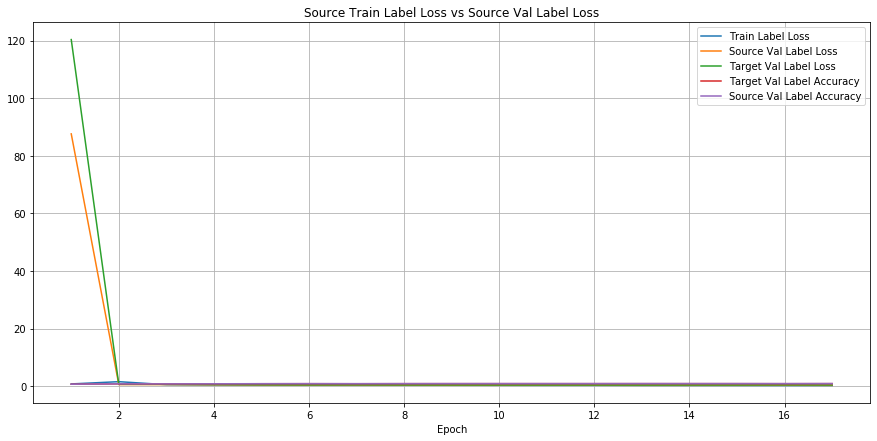

In [25]:
ax = get_loss_curve(experiment)
plt.show()

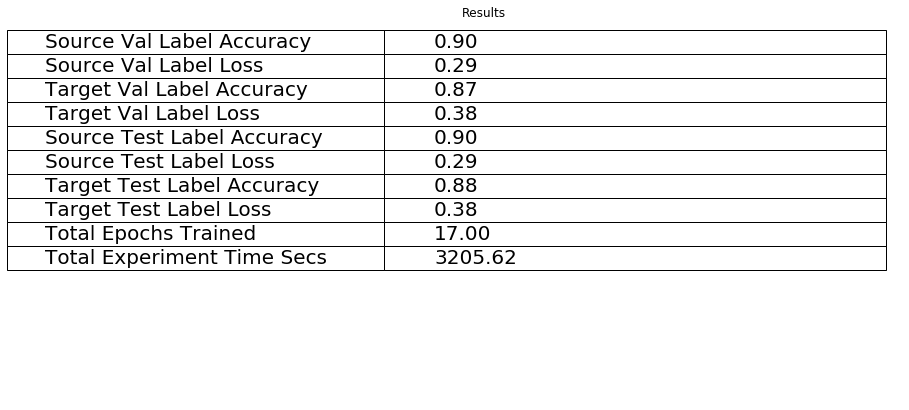

In [26]:
get_results_table(experiment)

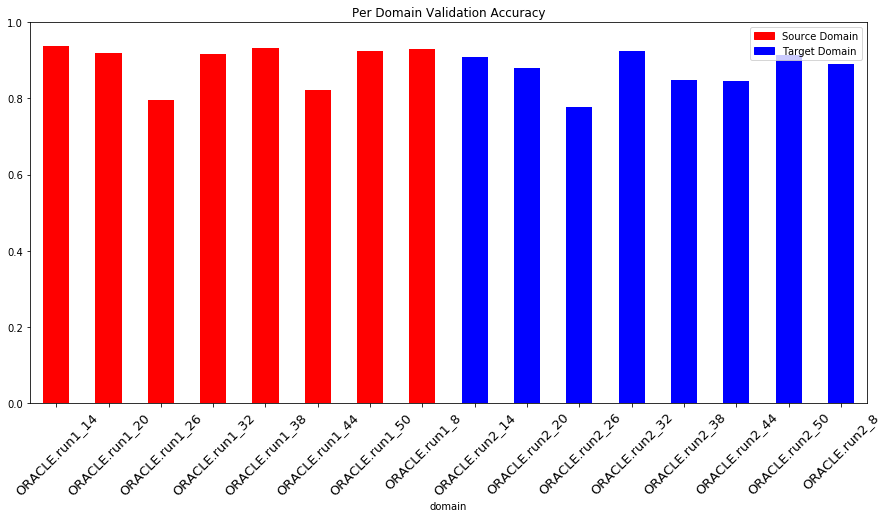

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8973958333333333 Target Test Label Accuracy: 0.8785481770833333
Source Val Label Accuracy: 0.8971354166666666 Target Val Label Accuracy: 0.8736653645833333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1_oracle.run1-oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480